In [1]:
#import packages
import requests
from bs4 import BeautifulSoup as bs
import os
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Initial URL
url = "https://search.sunbiz.org/Inquiry/CorporationSearch/SearchResults?inquiryType=ZipCode&searchNameOrder=AASHANNONENTERPRISES%20F449010&searchTerm=33320"

# List to store all rows from all pages
all_rows = []

headers = ['Name', 'Status', 'Corp_link']
# Open the CSV file in write mode with newline='' to prevent extra newline characters
with open('records.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile)
    
    # Write the headers to the CSV file
    writer.writerow(headers)

print("Headers added to the CSV file.")

while url:
    # Load web page
    r = requests.get(url)
    soup = bs(r.content, 'html.parser')
    
    # Find all table rows except the first one (header)
    rows = soup.find_all('tr')[1:]
    
    # Append rows to the list
    all_rows.extend(rows)
    
    # Find the link to the next page
    next_page_link = soup.find('a', title="Next List")
    
    # Check if there is a next page link
    if next_page_link:
        # Get the URL of the next page
        url = next_page_link.get('href')
        # If the URL is a relative path, make it absolute
        if not url.startswith('http'):
            url = "https://search.sunbiz.org" + url
    else:
        # If there is no next page link, break the loop
        break

# Open the existing CSV file in append mode
with open('records.csv', 'a', newline='', encoding='utf-8') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile)
    
    # Write data from all_rows list to the CSV file
    for row in all_rows:
        # Extract data from each row
        cols = row.find_all(['th', 'td'])
        name = cols[0].get_text(strip=True)
        status = cols[2].get_text(strip=True)
        link = row.find('a')['href']
        
        # Write data to CSV file
        writer.writerow([name, status, link])

print("Data appended to the CSV file successfully.")


Headers added to the CSV file.
Data appended to the CSV file successfully.


In [3]:
len(all_rows) 

1148

In [4]:
df = pd.read_csv('records.csv')
df.shape

(1148, 3)

In [5]:
df

,Name,Status,Corp_link
0,101ZENITH LLC,INACT,/Inquiry/CorporationSearch/SearchResultDetail?...
1,"1770PA, LLC",INACT,/Inquiry/CorporationSearch/SearchResultDetail?...
2,"1 MIRANDA ENTERPRISES, LLC",Active,/Inquiry/CorporationSearch/SearchResultDetail?...
3,"1ST GEN LAND TRUST, LLC",Active,/Inquiry/CorporationSearch/SearchResultDetail?...
4,"1ST STREET PROPERTIES, INC.",INACT,/Inquiry/CorporationSearch/SearchResultDetail?...
...,...,...,...
1143,YOUR HOLISTIC APPROACH LLC,Active,/Inquiry/CorporationSearch/SearchResultDetail?...
1144,"ZENITH ALLIANCE, LLC",Active,/Inquiry/CorporationSearch/SearchResultDetail?...
1145,ZOO FOOD AMERICA INC.,INACT,/Inquiry/CorporationSearch/SearchResultDetail?...
1146,ZOZO/COCO LOCO APPAREL LLC,Active,/Inquiry/CorporationSearch/SearchResultDetail?...


In [6]:
# Only Active ones
active_list = df[df['Status'] == 'Active']
active_list

,Name,Status,Corp_link
2,"1 MIRANDA ENTERPRISES, LLC",Active,/Inquiry/CorporationSearch/SearchResultDetail?...
3,"1ST GEN LAND TRUST, LLC",Active,/Inquiry/CorporationSearch/SearchResultDetail?...
6,365 FITNESS NOW INC,Active,/Inquiry/CorporationSearch/SearchResultDetail?...
13,4JS DESIGNS AND PRINT LLC,Active,/Inquiry/CorporationSearch/SearchResultDetail?...
23,"ABSOLUTE MARKET RESEARCH, INC.",Active,/Inquiry/CorporationSearch/SearchResultDetail?...
...,...,...,...
1142,"YANIPAINTS, LLC",Active,/Inquiry/CorporationSearch/SearchResultDetail?...
1143,YOUR HOLISTIC APPROACH LLC,Active,/Inquiry/CorporationSearch/SearchResultDetail?...
1144,"ZENITH ALLIANCE, LLC",Active,/Inquiry/CorporationSearch/SearchResultDetail?...
1146,ZOZO/COCO LOCO APPAREL LLC,Active,/Inquiry/CorporationSearch/SearchResultDetail?...


In [7]:
import csv
import requests
from bs4 import BeautifulSoup

# Define headers for the CSV file
headers = ['Corporation Name', 'company_type', 'FEI/EIN Number', 'Principal Address', 'Mailing Address', 'Registered Agent Name', 'Registered Agent Address']

# Write the headers to the CSV file
with open('corporation_info.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)

# Initialize a counter
total_links = len(active_list)
counter = 1

# Iterate through each unique link
for link in active_list['Corp_link']:
    # Print the progress
    print(counter, "of", total_links )
    print(f"Processing link: https://search.sunbiz.org/{link}")
    
    # Make an HTTP request to fetch the web page content
    response = requests.get(f"https://search.sunbiz.org/{link}")
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content using Beautiful Soup
        soup = BeautifulSoup(response.content, 'html.parser')

        try:
            # Extract relevant data from the webpage
            corporation_name = soup.find(class_="detailSection corporationName").find_all("p")[1].get_text(strip=True)
            company_type = soup.find('div', class_='detailSection corporationName').find('p').get_text(strip=True)
            fei_ein_number = soup.find("label", string="FEI/EIN Number").find_next("span").get_text(strip=True)
            principal_address = ' '.join([text if not text.strip() == '<br>' else ' ' for text in soup.find("span", string="Principal Address").find_next_sibling().stripped_strings])
            mailing_address = ' '.join([text if not text.strip() == '<br>' else ' ' for text in soup.find("span", string="Mailing Address").find_next_sibling().stripped_strings])
            registered_agent_name = soup.find("span", string="Registered Agent Name & Address").find_next_sibling().get_text(strip=True)
            registered_agent_address = ' '.join([text if not text.strip() == '<br>' else ' ' for text in soup.find("span", string="Registered Agent Name & Address").find_next_sibling().find_next_sibling().stripped_strings])
            
            print("corporation_name:", corporation_name)
            print("")
            print("----------------------------------------------------------------")
            
            # Write data to a list
            row_data = [corporation_name, company_type, fei_ein_number, principal_address, mailing_address, registered_agent_name, registered_agent_address]

            # Append data to the CSV file
            with open('corporation_info.csv', 'a', newline='', encoding='utf-8') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(row_data)

        except AttributeError as e:
            print(f"Error processing link: {link}. Error: {e}")

    # Increment the counter
    counter += 1

print("Data appended to the CSV file successfully.")


1 of 327
Processing link: https://search.sunbiz.org//Inquiry/CorporationSearch/SearchResultDetail?inquirytype=ZipCode&directionType=Initial&searchNameOrder=1MIRANDAENTERPRISES%20L230001080640&aggregateId=flal-l23000108064-285173a5-6b07-43a4-b653-7760e6afe27f&searchTerm=33320&listNameOrder=101ZENITH%20L160001100950
corporation_name: 1 MIRANDA ENTERPRISES, LLC

----------------------------------------------------------------
2 of 327
Processing link: https://search.sunbiz.org//Inquiry/CorporationSearch/SearchResultDetail?inquirytype=ZipCode&directionType=Initial&searchNameOrder=1STGENLANDTRUST%20L190000141300&aggregateId=flal-l19000014130-aae7b43b-4dfd-4a9a-8103-192586f4a78e&searchTerm=33320&listNameOrder=101ZENITH%20L160001100950
corporation_name: 1ST GEN LAND TRUST, LLC

----------------------------------------------------------------
3 of 327
Processing link: https://search.sunbiz.org//Inquiry/CorporationSearch/SearchResultDetail?inquirytype=ZipCode&directionType=Initial&searchNameOrd

In [8]:
corp_info = pd.read_csv('corporation_info.csv')
corp_info.shape

(327, 7)

In [9]:
corp_info

,Corporation Name,company_type,FEI/EIN Number,Principal Address,Mailing Address,Registered Agent Name,Registered Agent Address
0,"1 MIRANDA ENTERPRISES, LLC",Florida Limited Liability Company,NONE,"7875 NW 57TH STREET 26001 TAMARAC, FL 33320","7875 NW 57TH STREET 26001 TAMARAC, FL 33320","MIRANDA, TABITHA","7875 NW 57TH STREET 26001 TAMARAC, FL 33320"
1,"1ST GEN LAND TRUST, LLC",Florida Limited Liability Company,83-3118745,"1050 NW 4TH ST BOYNTON BEACH, FL 33435","PO BOX 25865 TAMARAC, FL 33320","JOSEPH, CATHIA","1050 NW 4th Street Boynton Beach, FL 33435"
2,365 FITNESS NOW INC,Florida Profit Corporation,38-3888336,"45 CANTERBURY LANE TAMARAC, FL 33319","P.O Box 26894 TAMARAC, FL 33320","ADJODHA, ROBERT","45 Canterbury LN TAMARAC, FL 33319"
3,4JS DESIGNS AND PRINT LLC,Florida Limited Liability Company,85-2953343,"2250 NW 52nd Court 1 Tamarac, FL 33309","P O Box 25021 Tamarac, FL 33320","BROOKES, JOEL A, SR","2250 NW 52nd Court 1 Tamarac, FL 33309"
4,"ABSOLUTE MARKET RESEARCH, INC.",Florida Profit Corporation,61-1600820,"7771 GRANDE STREET SUNRISE, FL 33351","PO BOX 25886 TAMARAC, FL 33320","JACKSON-DAYES, JOSEPHINE","7771 GRANDE STREET SUNRISE, FL 33351"
...,...,...,...,...,...,...,...
322,"YANIPAINTS, LLC",Florida Limited Liability Company,82-4398137,"6009 ORCHARD TREE TAMARAC, FL 33319","7875 NW 57th Street, Unit# 26108 Tamarac, FL 3...","DACOSTA, YANIQUE K","6009 Orchard Tree Lane Tamarac, FL 33319"
323,YOUR HOLISTIC APPROACH LLC,Florida Limited Liability Company,81-4213689,"8361 NW 47TH STREET LAUDERHILL, FL 33351","PO Box 25623 Tamarac, FL 33320","PREZEAU, YARAH","8361 NW 47TH STREET LAUDERHILL, FL 33351"
324,"ZENITH ALLIANCE, LLC",Florida Limited Liability Company,82-5455472,"7875 NW 57 STREET #2-5111 TAMARAC, FL 33320","7875 NW 57 STREET #2-5111 TAMARAC, FL 33320","Tomlinson, Karlene","7875 NW 57 STREET #2-5111 TAMARAC, FL 33320"
325,ZOZO/COCO LOCO APPAREL LLC,Florida Limited Liability Company,87-2635433,"1126 S Federal Hwy Fort Lauderdale, FL 33316","P.O. BOX 25678 TAMARAC, FL 33320","libertin, jodney","6142 HOLLYWOOD BLVD HOLLYWOOD, FL 33024"


In [10]:
print(corp_info.columns)

Index(['Corporation Name', 'company_type', 'FEI/EIN Number',
       'Principal Address', 'Mailing Address', 'Registered Agent Name',
       'Registered Agent Address'],
      dtype='object')


# Analysis

## 1. distribution of company types

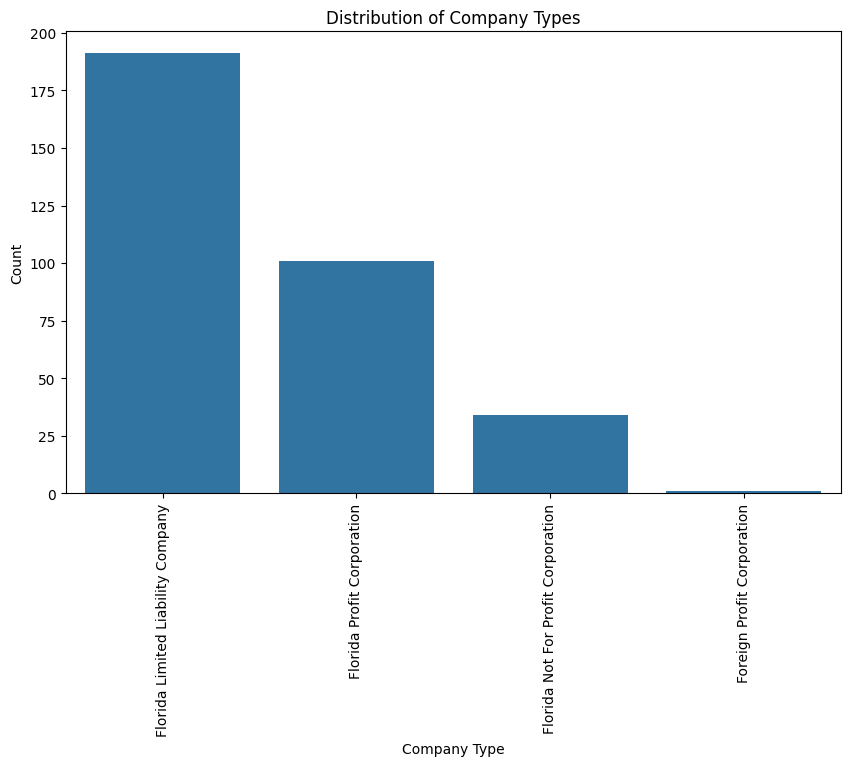

In [11]:
# Plot the distribution of company types
plt.figure(figsize=(10, 6))
sns.countplot(x='company_type', data=corp_info, order=corp_info['company_type'].value_counts().index)
plt.title('Distribution of Company Types')
plt.xlabel('Company Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


## 2. Person Vs. # of Corporations

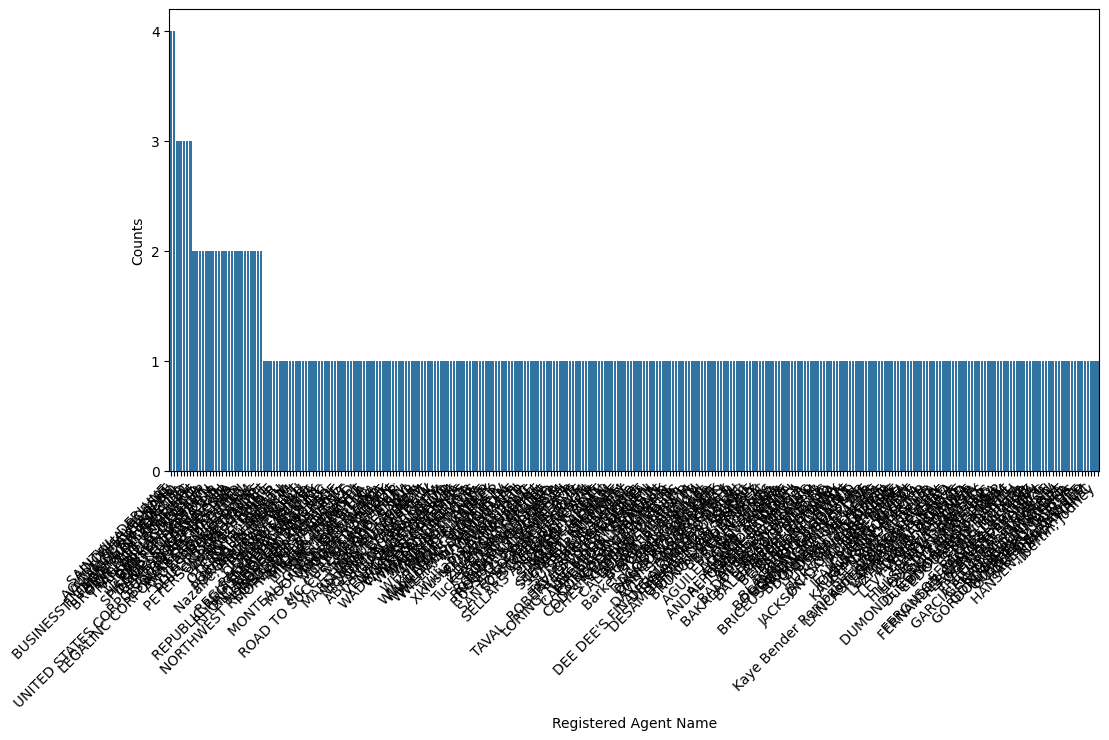

In [18]:
# Sort the DataFrame based on the counts of each unique 'Registered Agent Name'
name_groups_sorted = corp_info.groupby('Registered Agent Name').size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)

# Adjust the width of the figure
plt.figure(figsize=(12, 6))

# Create the bar plot
ax = sns.barplot(x='Registered Agent Name', y='Counts', data=name_groups_sorted)

# Set the format of the y-axis labels to integers
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

# Set the y-axis tick frequency to display only integers
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


## 3. Address Comparison

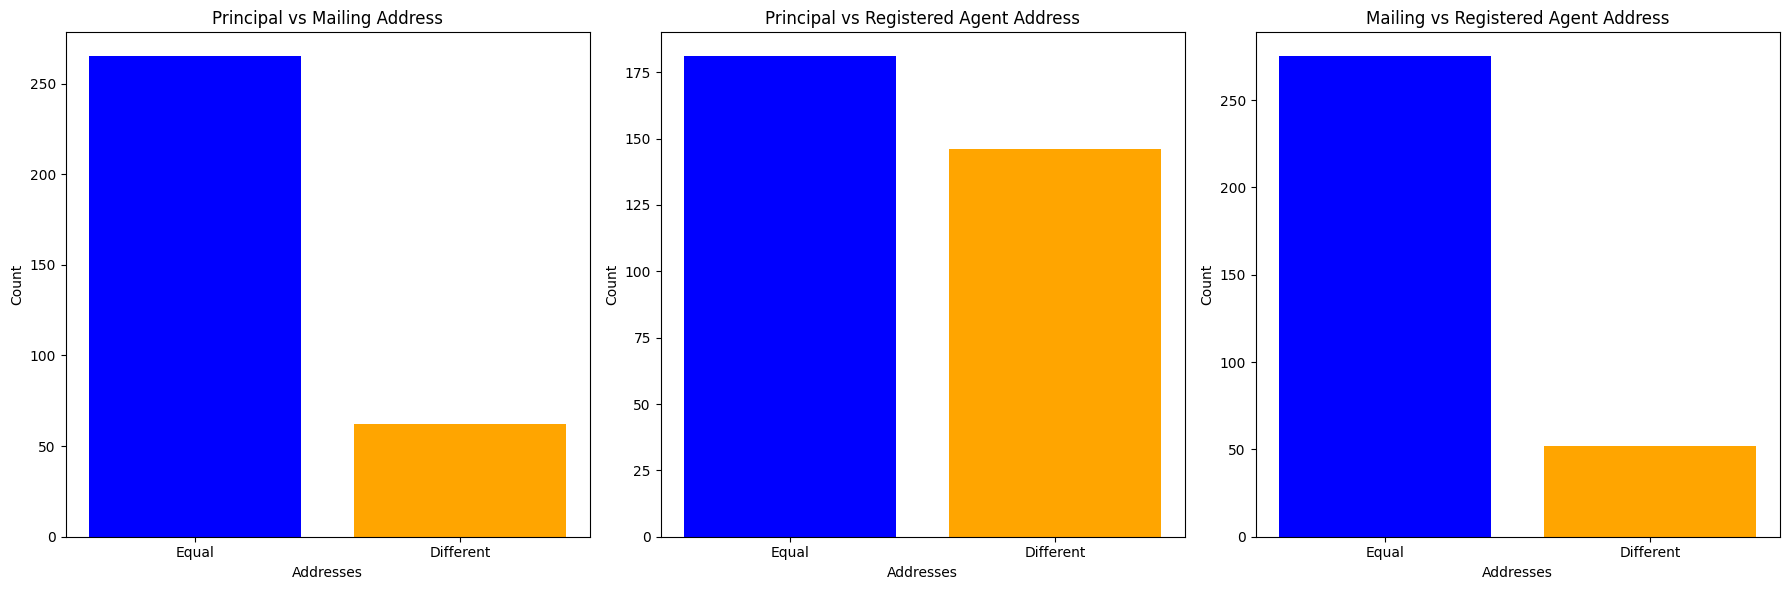

In [19]:
# Assuming you have separate columns for each address type
corp_info['Principal_Mailing_Equal'] = (corp_info['Principal Address'] == corp_info['Mailing Address'])
corp_info['Principal_Registered_Equal'] = (corp_info['Principal Address'] == corp_info['Registered Agent Address'])
corp_info['Mailing_Registered_Equal'] = (corp_info['Mailing Address'] == corp_info['Registered Agent Address'])

# Now you can count the number of equal and different addresses for each pair
principal_mailing_counts = corp_info['Principal_Mailing_Equal'].value_counts()
principal_registered_counts = corp_info['Principal_Registered_Equal'].value_counts()
mailing_registered_counts = corp_info['Mailing_Registered_Equal'].value_counts()

# Plot the bar charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Principal and Mailing Address
axes[0].bar(principal_mailing_counts.index.astype(str), principal_mailing_counts.values, color=['blue', 'orange'])
axes[0].set_title('Principal vs Mailing Address')
axes[0].set_xlabel('Addresses')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Equal', 'Different'])

# Plot for Principal and Registered Agent Address
axes[1].bar(principal_registered_counts.index.astype(str), principal_registered_counts.values, color=['blue', 'orange'])
axes[1].set_title('Principal vs Registered Agent Address')
axes[1].set_xlabel('Addresses')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Equal', 'Different'])

# Plot for Mailing and Registered Agent Address
axes[2].bar(mailing_registered_counts.index.astype(str), mailing_registered_counts.values, color=['blue', 'orange'])
axes[2].set_title('Mailing vs Registered Agent Address')
axes[2].set_xlabel('Addresses')
axes[2].set_ylabel('Count')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Equal', 'Different'])

plt.tight_layout()
plt.show()


## 4. Zip Code

In [20]:
corp_info['Principal Zip Code'] = corp_info['Principal Address'].str.replace('UN', '').str[-5:]

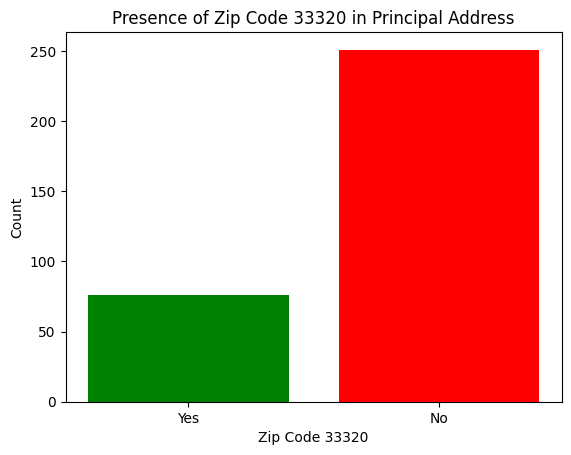

In [21]:
# Check if zip code is equal to "33320" and create a new column with 'Yes' or 'No'
corp_info['Zip Code 33320'] = corp_info['Principal Zip Code'] == '33320'

# Count occurrences of 'Yes' and 'No'
count_yes = (corp_info['Zip Code 33320'] == True).sum()
count_no = (corp_info['Zip Code 33320'] == False).sum()

# Create a bar plot
plt.bar(['Yes', 'No'], [count_yes, count_no], color=['green', 'red'])
plt.xlabel('Zip Code 33320')
plt.ylabel('Count')
plt.title('Presence of Zip Code 33320 in Principal Address')
plt.show()


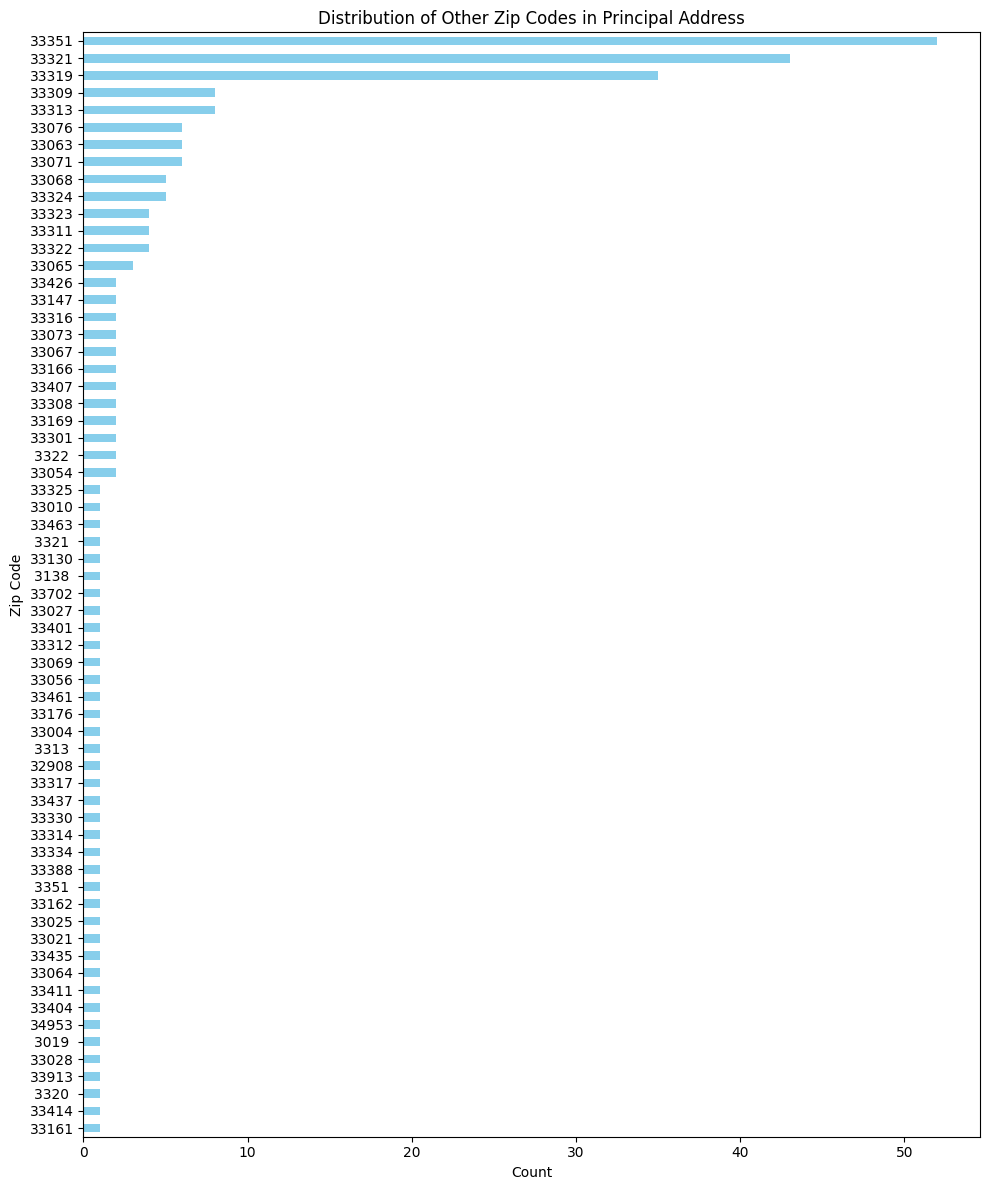

In [22]:
# Filter out zip code equal to "33320"
other_zip_codes = corp_info[corp_info['Principal Zip Code'] != '33320']

# Count occurrences of each unique zip code
zip_code_counts = other_zip_codes['Principal Zip Code'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(10, 12))  # Increase the figure height
zip_code_counts.sort_values().plot(kind='barh', color='skyblue')
plt.ylabel('Zip Code')
plt.xlabel('Count')
plt.title('Distribution of Other Zip Codes in Principal Address')

# Increase space between y-axis ticks
plt.yticks(rotation=0)  # Rotate the y-axis labels for better readability
plt.tight_layout()
plt.show()
